In [1]:
import src.tweet_data_processor as tdp
import src.twitter_queries as tq
import time
import random
import numpy as np
import pickle 
import matplotlib.pyplot as plt

search_app = tq.TwitterQueries()
dbs = tdp.TweetDataProcessor()

2024-04-25 22:53:47,731 - matplotlib - DEBUG - matplotlib data path: c:\Users\sofia\anaconda3\Lib\site-packages\matplotlib\mpl-data
2024-04-25 22:53:47,741 - matplotlib - DEBUG - CONFIGDIR=C:\Users\sofia\.matplotlib
2024-04-25 22:53:47,741 - matplotlib - DEBUG - interactive is False
2024-04-25 22:53:47,752 - matplotlib - DEBUG - platform is win32
2024-04-25 22:53:47,842 - matplotlib - DEBUG - CACHEDIR=C:\Users\sofia\.matplotlib
2024-04-25 22:53:47,852 - matplotlib.font_manager - DEBUG - Using fontManager instance from C:\Users\sofia\.matplotlib\fontlist-v330.json
2024-04-25 22:53:49,386 - apscheduler.scheduler - INFO - Adding job tentatively -- it will be properly scheduled when the scheduler starts
2024-04-25 22:53:49,386 - apscheduler.scheduler - INFO - Added job "Cache.save_to_disk" to job store "default"
2024-04-25 22:53:49,386 - apscheduler.scheduler - INFO - Scheduler started
2024-04-25 22:53:49,386 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 22:53:49,408

## Database Stats

In [2]:
cursor = dbs.mysql_conn.cursor(buffered=True)
cursor.execute('SELECT count(*) as n_users FROM twitter.users')
fname = cursor.fetchone()[0]
print(fname,'users in MySQL')

75377 users in MySQL


In [3]:
cursor.execute('SELECT count(distinct hashtag) as n_users FROM twitter.hashtags')
fname = cursor.fetchone()[0]
print(fname,'hashtags in MySQL')

6008 hashtags in MySQL


In [4]:
print(dbs.tweet_collection.count_documents({}),'tweets in MongoDB')

86656 tweets in MongoDB


In [5]:
res = dbs.neo4j_connection.execute_query("MATCH ()-[r]->() RETURN count(r) as n")
print(res.records[0][0],'relationships between users in Neo4J')

62744 relationships between users in Neo4J


## Experiments

In [6]:
n_experiments = 10000
stats_sample = 1000

query = """
SELECT id_str FROM twitter.users
ORDER BY RAND()
LIMIT 5000
"""
cursor.execute(query)
sample_users = cursor.fetchall()
sample_users_list = [x[0] for x in sample_users]

## for hashtags, focusing only on the ones with 1 twitter
query = """
WITH tb as 
(SELECT hashtag
FROM (SELECT hashtag, count(tweet_id) as n_tweet FROM twitter.hashtags
GROUP BY 1
HAVING n_tweet = 1) a)

SELECT hashtag, tweet_id
FROM twitter.hashtags a
WHERE hashtag in (select hashtag from tb)
ORDER BY RAND()
LIMIT 3000
"""
cursor.execute(query)
sample_hashtags = cursor.fetchall()
sample_hashtags_list = [x[0] for x in sample_hashtags]
tweets_hashtags_list = [x[1] for x in sample_hashtags]

tweets = dbs.tweet_collection.aggregate([{ "$sample": { "size": 5000 } }])
tweets_list = [i['id_str'] for i in tweets]

#### Hashtags

In [7]:
time_list_cache = []
time_list_wo_cache = []

for i in range(0,n_experiments):
    number = random.randint(0, len(sample_hashtags_list)-1)
    hashtag_id = sample_hashtags_list[number]
    tweet_id = tweets_hashtags_list[number]
    is_in_cache = search_app.tweet_cache.get(tweet_id) is not None
    tic = time.perf_counter()
    search_app.search_tweets_by_hashtag(hashtag_id)
    toc = time.perf_counter()
    if is_in_cache:
        time_list_cache.append(toc-tic)
    else:
        time_list_wo_cache.append(toc-tic)
    
results = {
    'with_cache':time_list_cache,
    'without_cache':time_list_wo_cache
}

with open('hashtag_results.pkl', 'wb') as f:
    pickle.dump(results, f)

2024-04-25 22:54:49,396 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 22:54:49,396 - apscheduler.executors.default - INFO - Running job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 22:54:49 EDT)" (scheduled at 2024-04-25 22:54:49.386195-04:00)
2024-04-25 22:54:49,396 - apscheduler.scheduler - DEBUG - Next wakeup is due at 2024-04-25 22:55:49.386195-04:00 (in 59.989893 seconds)
2024-04-25 22:54:49,456 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 22:54:49,456 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 22:54:49,462 - apscheduler.executors.default - INFO - Running job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 22:55:49 EDT)" (scheduled at 2024-04-25 22:54:49.430273-04:00)
2024-04-25 22:54:49,462 - apscheduler.scheduler - DEBUG - Next wakeup is due at 2024-04-25 22:55:49.430273-04:00 (in 59.967429 seconds)
2024-04-25 22:54:49,462 - apscheduler.executors.default 

Without cache
mean: 47.0149 ms
std: 12.0805 ms


Text(0.5, 1.0, 'Timings of hashtag search queries \n without cache data')

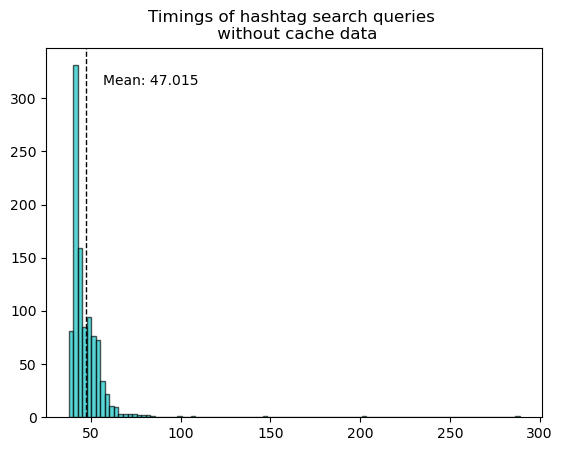

2024-04-25 23:01:49,397 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:01:49,398 - apscheduler.scheduler - DEBUG - Next wakeup is due at 2024-04-25 23:02:49.386195-04:00 (in 59.987639 seconds)
2024-04-25 23:01:49,399 - apscheduler.executors.default - INFO - Running job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 23:02:49 EDT)" (scheduled at 2024-04-25 23:01:49.386195-04:00)
2024-04-25 23:01:49,445 - apscheduler.executors.default - INFO - Job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 23:02:49 EDT)" executed successfully
2024-04-25 23:01:49,446 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:01:49,446 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:01:49,449 - apscheduler.scheduler - DEBUG - Next wakeup is due at 2024-04-25 23:02:49.430273-04:00 (in 59.980716 seconds)
2024-04-25 23:01:49,449 - apscheduler.executors.default - INFO - Running job "Cache.save_t

In [ ]:
time_list_wo_cache = np.array(time_list_wo_cache)
chosen_ids = random.sample(range(0,len(time_list_wo_cache)), stats_sample)
print('Without cache')    
print('mean:',f'{np.mean(time_list_wo_cache[chosen_ids])*1000:0.4f} ms')
print('std:',f'{np.std(time_list_wo_cache[chosen_ids])*1000:0.4f} ms')

x = (time_list_wo_cache[chosen_ids]*1000)
plt.hist(x, bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.2, max_ylim*0.9, 'Mean: {:.3f}'.format(x.mean()))
plt.title('Timings of hashtag search queries \n without cache data')


With cache
mean: 30.5854 ms
std: 7.8370 ms


Text(0.5, 1.0, 'Timings of hashtag search queries \n with cache data')

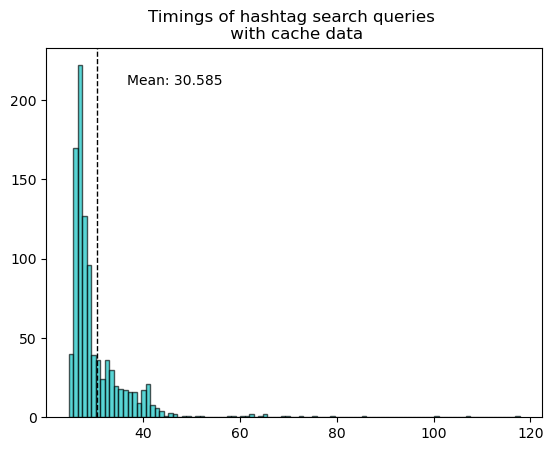

In [14]:
time_list_cache = np.array(time_list_cache)
chosen_ids = random.sample(range(0,len(time_list_cache)), stats_sample)
print('With cache')  
print('mean:',f'{np.mean(time_list_cache[chosen_ids])*1000:0.4f} ms')
print('std:',f'{np.std(time_list_cache[chosen_ids])*1000:0.4f} ms')

x = (time_list_cache[chosen_ids]*1000)
plt.hist(x, bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.2, max_ylim*0.9, 'Mean: {:.3f}'.format(x.mean()))
plt.title('Timings of hashtag search queries \n with cache data')

#### User

In [15]:
time_list_cache = []
time_list_wo_cache = []

for i in range(0,n_experiments):
    number = random.randint(0, len(sample_users_list)-1)
    user_id = sample_users_list[number]
    is_in_cache = search_app.user_cache.get(user_id) is not None
    tic = time.perf_counter()
    search_app.get_user_data([user_id])
    toc = time.perf_counter()
    if is_in_cache:
        time_list_cache.append(toc-tic)
    else:
        time_list_wo_cache.append(toc-tic)

results = {
    'with_cache':time_list_cache,
    'without_cache':time_list_wo_cache
}


with open('user_results.pkl', 'wb') as f:
    pickle.dump(results, f)



2024-04-25 23:02:49,397 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:02:49,399 - apscheduler.scheduler - DEBUG - Next wakeup is due at 2024-04-25 23:03:49.386195-04:00 (in 59.986717 seconds)
2024-04-25 23:02:49,401 - apscheduler.executors.default - INFO - Running job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 23:03:49 EDT)" (scheduled at 2024-04-25 23:02:49.386195-04:00)
2024-04-25 23:02:49,441 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:02:49,451 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:02:49,454 - apscheduler.scheduler - DEBUG - Next wakeup is due at 2024-04-25 23:03:49.430273-04:00 (in 59.976165 seconds)
2024-04-25 23:02:49,455 - apscheduler.executors.default - INFO - Running job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 23:03:49 EDT)" (scheduled at 2024-04-25 23:02:49.430273-04:00)
2024-04-25 23:02:49,485 - apscheduler.scheduler - DEBUG 

Without cache
mean: 29.9606 ms
std: 17.7826 ms


Text(0.5, 1.0, 'Timings of user search queries \n without cache data')

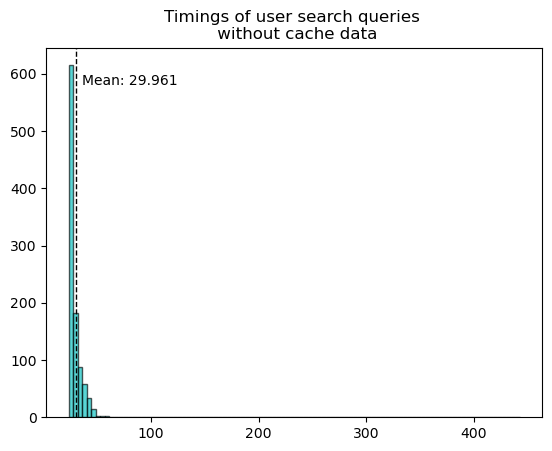

In [16]:
time_list_wo_cache = np.array(time_list_wo_cache)
chosen_ids = random.sample(range(0,len(time_list_wo_cache)), stats_sample)
print('Without cache')    
print('mean:',f'{np.mean(time_list_wo_cache[chosen_ids])*1000:0.4f} ms')
print('std:',f'{np.std(time_list_wo_cache[chosen_ids])*1000:0.4f} ms')

x = (time_list_wo_cache[chosen_ids]*1000)
plt.hist(x, bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.2, max_ylim*0.9, 'Mean: {:.3f}'.format(x.mean()))
plt.title('Timings of user search queries \n without cache data')

With cache
mean: 0.0021 ms
std: 0.0011 ms


Text(0.5, 1.0, 'Timings of user search queries \n with cache data')

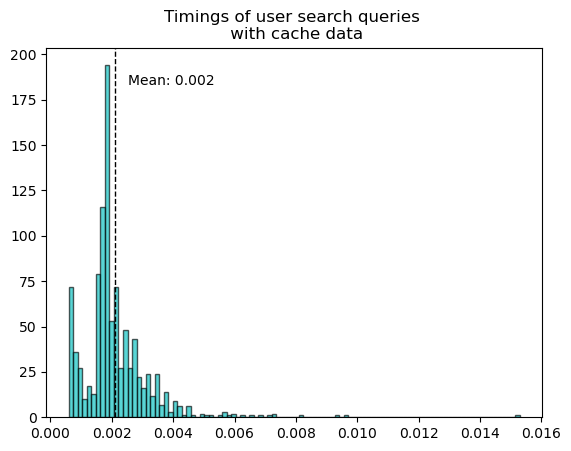

In [17]:

time_list_cache = np.array(time_list_cache)
chosen_ids = random.sample(range(0,len(time_list_cache)), stats_sample)
print('With cache')  
print('mean:',f'{np.mean(time_list_cache[chosen_ids])*1000:0.4f} ms')
print('std:',f'{np.std(time_list_cache[chosen_ids])*1000:0.4f} ms')

x = (time_list_cache[chosen_ids]*1000)
plt.hist(x, bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.2, max_ylim*0.9, 'Mean: {:.3f}'.format(x.mean()))
plt.title('Timings of user search queries \n with cache data')

#### Tweet

In [18]:
time_list_cache = []
time_list_wo_cache = []


for i in range(0,n_experiments):
    number = random.randint(0, len(tweets_list)-1)
    tweet_id = tweets_list[number]
    is_in_cache = search_app.tweet_cache.get(tweet_id) is not None
    tic = time.perf_counter()
    search_app.fetch_tweets_from_mongodb([tweet_id])
    toc = time.perf_counter()
    if is_in_cache:
        time_list_cache.append(toc-tic)
    else:
        time_list_wo_cache.append(toc-tic)
    
results = {
    'with_cache':time_list_cache,
    'without_cache':time_list_wo_cache
}

with open('tweet_results.pkl', 'wb') as f:
    pickle.dump(results, f)

2024-04-25 23:06:49,403 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:06:49,404 - apscheduler.scheduler - DEBUG - Next wakeup is due at 2024-04-25 23:07:49.386195-04:00 (in 59.981920 seconds)
2024-04-25 23:06:49,404 - apscheduler.executors.default - INFO - Running job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 23:07:49 EDT)" (scheduled at 2024-04-25 23:06:49.386195-04:00)
2024-04-25 23:06:49,437 - apscheduler.executors.default - INFO - Job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 23:07:49 EDT)" executed successfully
2024-04-25 23:06:49,457 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:06:49,468 - apscheduler.scheduler - DEBUG - Next wakeup is due at 2024-04-25 23:07:49.430273-04:00 (in 59.962194 seconds)
2024-04-25 23:06:49,468 - apscheduler.executors.default - INFO - Running job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 23:07:49 EDT)" (schedu

Without cache
mean: 17.2492 ms
std: 11.6730 ms


Text(0.5, 1.0, 'Timings of tweet search queries \n without cache data')

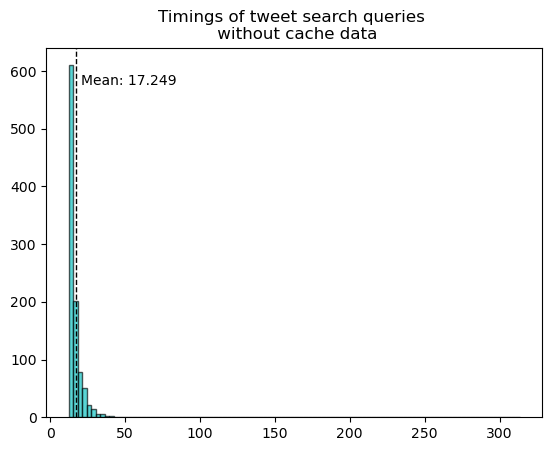

In [19]:
time_list_wo_cache = np.array(time_list_wo_cache)
chosen_ids = random.sample(range(0,len(time_list_wo_cache)), stats_sample)
print('Without cache')    
print('mean:',f'{np.mean(time_list_wo_cache[chosen_ids])*1000:0.4f} ms')
print('std:',f'{np.std(time_list_wo_cache[chosen_ids])*1000:0.4f} ms')

x = (time_list_wo_cache[chosen_ids]*1000)
plt.hist(x, bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.2, max_ylim*0.9, 'Mean: {:.3f}'.format(x.mean()))
plt.title('Timings of tweet search queries \n without cache data')

With cache
mean: 0.0019 ms
std: 0.0017 ms


Text(0.5, 1.0, 'Timings of tweet search queries \n with cache data')

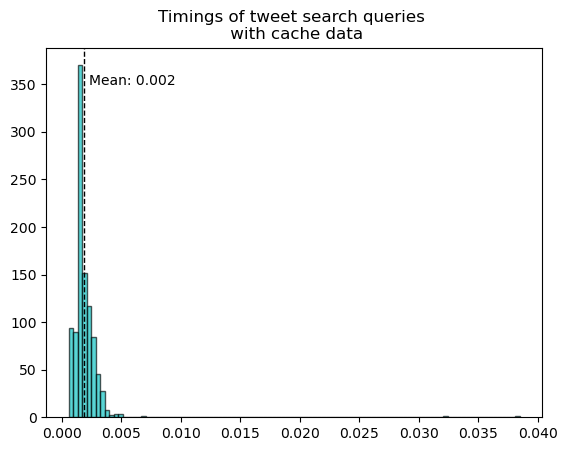

2024-04-25 23:08:49,398 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:08:49,400 - apscheduler.scheduler - DEBUG - Next wakeup is due at 2024-04-25 23:09:49.386195-04:00 (in 59.985909 seconds)
2024-04-25 23:08:49,400 - apscheduler.executors.default - INFO - Running job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 23:09:49 EDT)" (scheduled at 2024-04-25 23:08:49.386195-04:00)
2024-04-25 23:08:49,430 - apscheduler.executors.default - INFO - Job "Cache.save_to_disk (trigger: interval[0:01:00], next run at: 2024-04-25 23:09:49 EDT)" executed successfully
2024-04-25 23:08:49,442 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:08:49,443 - apscheduler.scheduler - DEBUG - Looking for jobs to run
2024-04-25 23:08:49,443 - apscheduler.scheduler - DEBUG - Next wakeup is due at 2024-04-25 23:09:49.430273-04:00 (in 59.987254 seconds)
2024-04-25 23:08:49,446 - apscheduler.executors.default - INFO - Running job "Cache.save_t

In [ ]:
time_list_cache = np.array(time_list_cache)
chosen_ids = random.sample(range(0,len(time_list_cache)), stats_sample)
print('With cache')  
print('mean:',f'{np.mean(time_list_cache[chosen_ids])*1000:0.4f} ms')
print('std:',f'{np.std(time_list_cache[chosen_ids])*1000:0.4f} ms')

x = (time_list_cache[chosen_ids]*1000)
plt.hist(x, bins=100, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.2, max_ylim*0.9, 'Mean: {:.3f}'.format(x.mean()))
plt.title('Timings of tweet search queries \n with cache data')